In [1]:
import pandas as pd
import lifetimes
import datetime as dt
#import warnings


## Importing data and converting into just Cust ID, Date and Sales amount

In [2]:
df = pd.read_excel("C:/Users/jeraldseow/Desktop/learning session/CLV/Online Retail.xlsx")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.date

df = df[pd.notnull(df["CustomerID"])]
df = df[(df["Quantity"]>0)]
df['Sales'] = df["Quantity"] * df["UnitPrice"]
cols_of_interest = ["CustomerID", "InvoiceDate", "Sales"]
df = df[cols_of_interest]
print(df.head())
print(df["CustomerID"].nunique())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
4339


## Transforming transaction data into CLV data format

- Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
- T represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

In [3]:
from lifetimes.plotting import *
from lifetimes.utils import *
#from lifetimes.estimation import *

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', 
                                          monetary_value_col='Sales', 
                                          observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [4]:
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))
data['frequency'].plot(kind='hist', bins=50)

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


## Training BetaGeoFitter model with data

The BG model helps us perform some basic frequency / recency analysis

In [5]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


## Frequency matrix of probability of number of purchases in 1 unit time, given customer recency & frequency

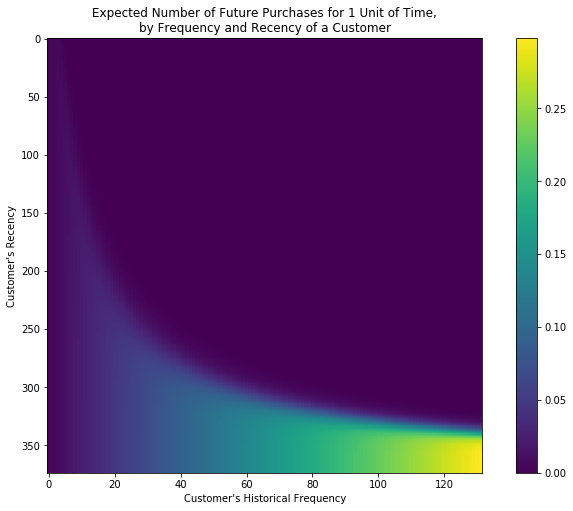

In [6]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 120 times from us, and their latest purchase was when they were 350 days old (given the individual is 350 days old), then they are our best customer (bottom-right). Customers who have purchased a lot and purchased recently will likely be the best customers in the future.

Customers who have purchased a lot but not recently (top-right corner), have probably dropped out.

There’s also that beautiful “tail” around (20,250). That represents the customer who buys infrequently, and we’ve not seen him or her very recently, so they might buy again - we’re not sure if they dropped out or just between purchases.

We can predict which customers are still alive:

## Probability matrix of whether customer is still alive, given frequency and recency

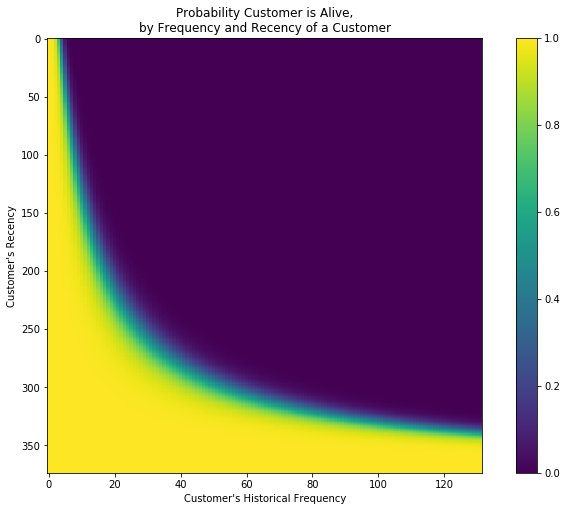

In [7]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

Customers who have purchased recently are almost surely "alive".

Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right.

The matrix lets us estimate a behavioral propensity that we can never observe if someone is alive or not.

## Order of Customers who have the highest chance of making a purchase given their frequency and recency

In [8]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581
14911.0,131.0,372.0,373.0,1093.661679,0.298312


We can see that the customer who has made 131 purchases, and bought very recently from us, has a probability of 29.8% to buy again in the next period (tomorrow).

## Testing accuracy of our model in judging future repeat transactions

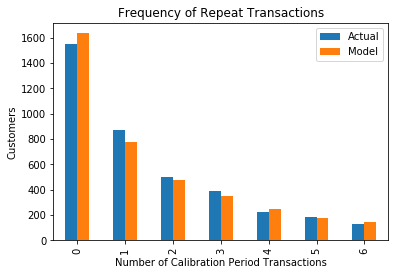

In [9]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

This plot tells us for all customers in our data, how many purchases they make in our observation period, and what does the model predict

## Parittion data into train & test data set to test

We can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition our dataset like this:

(Calibration = Training, Holdout/Observation = Testing)

In [10]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        121.0  183.0                4.0   
12348.0               2.0        110.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               3.0         34.0  112.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                  184  
12347.0                  184  
12348.0                  184  
12350.0                  184  
12352.0                  184  


C:\Users\jeraldseow\AppData\Local\Continuum\anaconda3\lib\site-packages\lifetimes\fitters\__init__.py:82: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(pd.Series(np.diag(self.variance_matrix_.values), index=self.params_.index))


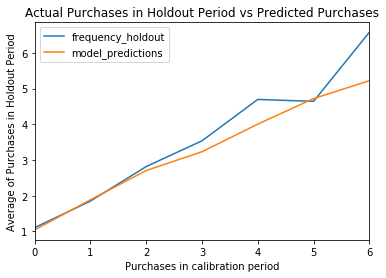

In [11]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

Based on customer history, we can predict what an individuals future purchases might look like:

In [12]:
t = 10
individual = data.iloc[20]
print("Customer "+ str(individual.name) + " is likely to make " + str(bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])) + " purchases in the next 10 days")

Customer 12370.0 is likely to make 0.08876045771799122 purchases in the next 10 days


In [13]:
individual.name

12370.0

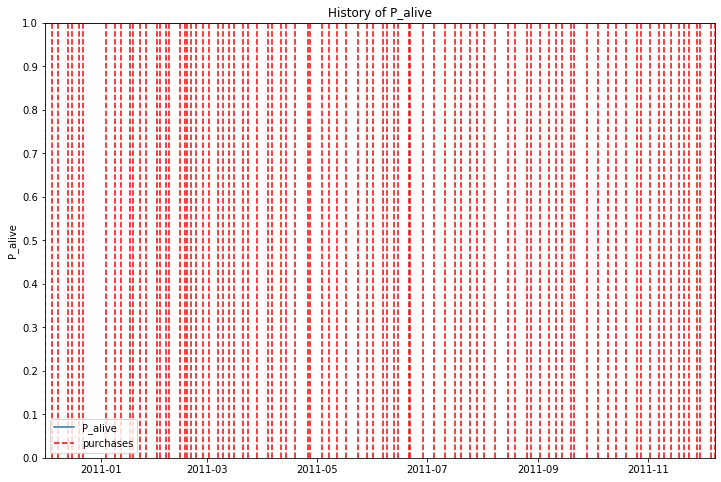

In [14]:
from lifetimes.plotting import plot_history_alive
#import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

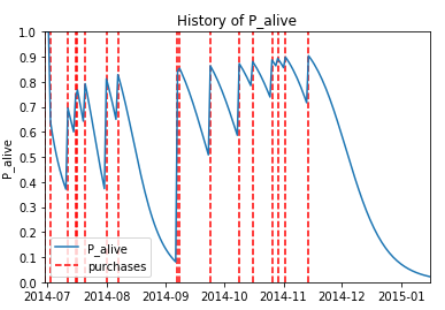

#### Estimating customer lifetime value using the Gamma-Gamma model

For this whole time we didn’t take into account the economic value of each transaction and we focused mainly on transactions’ occurrences. To estimate this we can use the Gamma-Gamma submodel. But first we need to create summary data from transactional data also containing economic values for each transaction (i.e. profits or revenues).

In [15]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015656
12348.0           3.0    283.0  358.0      301.480000             0.008956
12352.0           6.0    260.0  296.0      368.256667             0.018697
12356.0           2.0    303.0  325.0      269.905000             0.007172
12358.0           1.0    149.0  150.0      683.200000             0.008340
2790


#### The Gamma-Gamma model and the independence assumption

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [16]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


In [17]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


We can now estimate the average transaction value:

In [18]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64


In [19]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).mean(),
    data[data['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 441.12840327472423, Average profit: 477.3586892535673


While for computing the total CLV using the DCF method adjusting for cost of capital:

In [20]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(data['frequency'], data['recency'], data['T'])

model = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # lifetime expected for the user in months
    discount_rate=0.01) # monthly discount rate ~ 12.7% annually

print(model.head(10))

CustomerID
12346.0     295.248495
12347.0    3010.933997
12348.0    1008.692677
12349.0    1337.106427
12350.0     306.932977
12352.0    2372.739690
12353.0     426.098903
12354.0     386.464312
12355.0     411.043379
12356.0     784.161526
Name: clv, dtype: float64


In [24]:
#Find out which customers are the most valuable
model.sort_values(ascending = False)

CustomerID
14646.0    222128.930290
18102.0    178895.333435
16446.0    175531.468535
17450.0    147476.621010
14096.0    127589.202889
14911.0    109442.132668
12415.0     96290.227222
14156.0     89410.334970
17511.0     67660.407580
16029.0     58729.618772
16684.0     51363.457786
13694.0     48895.458599
15311.0     46235.466090
13089.0     44886.956392
17949.0     43714.700430
15769.0     42769.143468
14298.0     38044.238230
14088.0     36429.747826
15061.0     34488.751977
12931.0     32612.838358
17841.0     31153.588100
13798.0     28300.855356
16013.0     27690.871275
17389.0     26882.678864
12748.0     26026.751940
16422.0     25613.901454
15838.0     25093.368972
13098.0     24774.662303
17404.0     23991.828783
16333.0     22713.760207
               ...      
16752.0       263.784103
16754.0       263.784103
13011.0       263.784103
13108.0       263.784103
12855.0       263.784103
12738.0       263.784103
14576.0       263.784103
17925.0       263.784103
16510.0       

In [21]:
sum(model.values) # monthly discount rate ~ 12.7% annually

8648021.172659663